## In this notebook we'll parse CSV statement from Bank of america and try to visualize spending

1. let's download a CSV statement from Bank Of America website

TBD screenshot here

### reading CSV statement into a list of plain dicts.

In [81]:
from csv import DictReader

with open('/Users/rinozemt/Downloads/February2020_4216.csv') as csvfile:
    reader = DictReader(csvfile)
    transactions_list = list(dict(x) for x in reader)

### 1. Pre-process data, just cleanup

1. change field names. what we want is 'date', 'description', 'ref_num', 'amount', 'address'
2. change value types - amount is decimal and date is datetime.
3. clean description, in many cases 'address' is also written in 'description'.

#### BofA specific mapping of fields. Chase or Wells Fargo would be different.

In [82]:
## TODO: that should be in the yaml config file.
bofa_columns_meta = {
    "Posted Date": {
        "name": "date",
        "type": "datetime",
        "description": "date of the transaction"
    },
    "Reference Number": {
        "name": "ref_num",
        "type": "str",
        "description": "transaction / reference number"
    },
    "Payee": {
        "name": "description",
        "type": "str",
        "description": "transaction description" 
    },
    "Address": {
        "name": "address",
        "type": "str",  # for now, may be address as a type???
        "description": "address where trasaction happened, most likely just a city"
    },
    "Amount": {
        "name": "amount",
        "type": "float",
        "description": "amount of money paid"  # wtf there is no currency
    }
}

This code is pretty generic, and does actual clean up, uses BofA specific metadata from above.

In [83]:
from dateutil.parser import parse
#from decimal import Decimal
from typing import List
import re


def clean_name_and_type(key: str, value: str):
    """Takes key, value and returns new key, value
    
    For example:
    standardize_item("Amount", "27.97") returns ("amount", Decimal("27.97"))
    """
    column_meta = bofa_columns_meta[key]
    new_key = column_meta["name"]
    column_type = column_meta["type"]
    if column_type == "datetime":
        new_value = parse(value)
    elif column_type == "float":
        new_value = float(value)
    elif column_type == "str":
        new_value = str(value)
        new_value = re.sub('\s+',' ', new_value.lower().strip())
    else:
        raise Exception("unknown column type")
    return new_key, new_value
        
def clean_description_from_address(tx):
    """See lots of transactions where Address is also appended to the description. Let's remove that."""
    address = tx["address"]
    description = tx['description']
    if not address:
        return description
    address_without_spaces = address.replace(' ', '')
    description_without_spaces = description.replace(' ', '')
    if description_without_spaces.endswith(address_without_spaces):
        #print("NEED CLEANUP")  ## TODO: remove that
        # need to remove address from payee
        # possibilities are:
        # sunnyvale CA -> SunnyvaleCA
        # mountain view ca -> mountain viewca
        # sunnyvale ca -> sunnyvale ca
        if description.endswith(address):
            #print("remove full address")
            return description.replace(address, '').strip()
        k = address.rfind(" ")
        address_without_last_space = address[:k]  + address[k+1:]
        #print(address_without_last_space)
        if description.endswith(address_without_last_space):
            #print("remove partial address")
            return description.replace(address_without_last_space, '').strip()
    return description


def clean_transaction(transaction: dict):
    """Change field names to something that will be used with all the banks.
    
    also cleans up 'description' field from address.
    """
    formatted_tx = {}
    for k, v in transaction.items():
        new_key, new_value = clean_name_and_type(k, v)
        formatted_tx[new_key] = new_value
    clean_description = clean_description_from_address(formatted_tx)
    # square also prefixes their transactions with 'sq *', let's remove it.
    if clean_description.startswith("sq *"):
        formatted_tx['point_of_sale'] = 'square'
        clean_description = clean_description.replace("sq *", "")
    if formatted_tx['amount'] > 0:
        formatted_tx['type'] = 'credit'
    else:
        formatted_tx['type'] = 'debit'

    formatted_tx['description'] = clean_description
    return formatted_tx



def clean_transactions(transactions: List[dict]):
    """Cleans all transactions"""
    clean_txs = []
    for tx in transactions:
        clean_tx = clean_transaction(tx)
        clean_txs.append(clean_tx)
    return clean_txs

clean_txs = clean_transactions(transactions_list)

In [84]:
clean_txs

[{'date': datetime.datetime(2020, 2, 12, 0, 0),
  'ref_num': '',
  'description': 'interest charged on purchases',
  'address': '',
  'amount': -27.81,
  'type': 'debit'},
 {'date': datetime.datetime(2020, 2, 12, 0, 0),
  'ref_num': '04383204320021200050652',
  'description': 'payment - thank you',
  'address': '',
  'amount': 2426.09,
  'type': 'credit'},
 {'date': datetime.datetime(2020, 2, 11, 0, 0),
  'ref_num': '24431060041975016990209',
  'description': 'safeway #308',
  'address': 'half moon bay ca',
  'amount': -21.41,
  'type': 'debit'},
 {'date': datetime.datetime(2020, 2, 10, 0, 0),
  'ref_num': '',
  'description': 'late fee for payment due',
  'address': '',
  'amount': -25.0,
  'type': 'debit'},
 {'date': datetime.datetime(2020, 2, 10, 0, 0),
  'ref_num': '24492150039637129230449',
  'description': 'philz coffee',
  'address': 'www.philzcoff ca',
  'amount': -3.6,
  'type': 'debit'},
 {'date': datetime.datetime(2020, 2, 7, 0, 0),
  'ref_num': '24492150038637025023659',
  

So far it's only based on BofA, when I get to Chase, i'll fine similarities.

### 2. try to infer merchant and category

for that for now we do mostly regex matching.
as this list grows it will be moved to the database.
but for better GitHub visibility, yaml might work for first 100 or so.

TODO:
should we infer merchant, and from the merchant infer category and tags?
or one mapping is ok?

In [85]:
import re
import json

with open('description_matchers.json') as matchers_config:
    matchers = json.loads(matchers_config.read())

def try_match(description, matcher):
    match = matcher["match"]
    if match["type"] == "exact":
        #print(description, match["exact"])
        if description == match["exact"]:
            return matcher["assign"]
    elif match["type"] == "keyword":
        #print(description, match["exact"])
        parts = re.split(' |\.|,|\n', description)
        if match["keyword"] in parts:
            return matcher["assign"]
    elif match["type"] == "regex":
        #print(match["regex"], description)
        re_match = re.match(match["regex"], description)
        if re_match:
            assign_values = matcher["assign"]
            if re_match.groupdict():
                assign_values.update(re_match.groupdict())
            return assign_values
    return None

def parse_description(description):
    for matcher in matchers:
        #print(matcher)
        assign_values = try_match(description, matcher)
        if assign_values:
            return assign_values

def enhance_transaction(tx):
    values_to_add = parse_description(tx["description"])
    tx_copy = tx.copy()
    if values_to_add:
        if "merchant" not in values_to_add:
            # TBD if this is what we want
            values_to_add["merchant"] = tx["description"]
        tx_copy.update(values_to_add)
    
   
    return tx_copy

def enhance_transactions(txs):
    result = []
    for tx in clean_txs:
        #print(tx)
        tx_copy = enhance_transaction(tx)
        result.append(tx_copy)
    return result


enhanced_txs = enhance_transactions(clean_txs)

### 3. now all is categorized, let's try to slice and dice

In [86]:
import pandas as pd

df = pd.DataFrame(enhanced_txs) 

In [87]:
df = df.set_index('date')

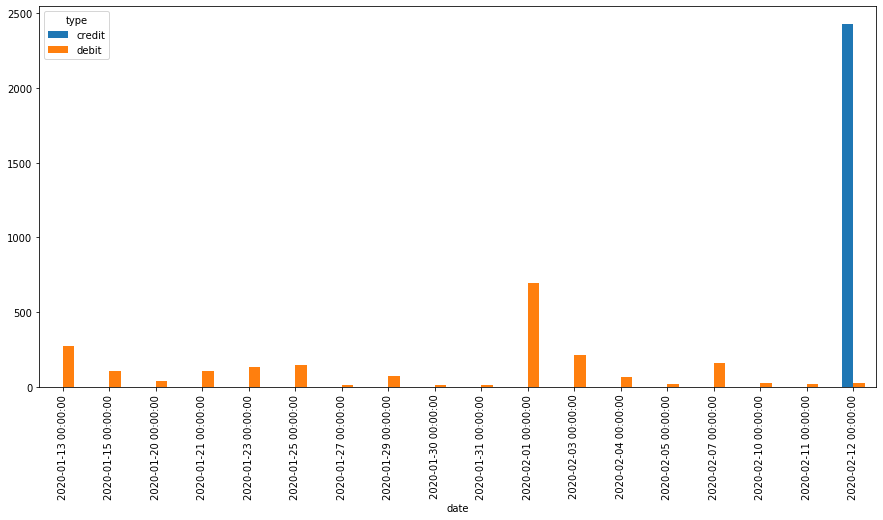

In [88]:
df.groupby(['date', 'type'])['amount'].agg('sum').map(abs).unstack().plot(kind='bar', figsize=(15,7))

category
business      39.00
cafe          57.15
dining       115.41
fees          52.81
furniture    176.51
groceries    919.64
health        15.00
pharmacy      72.97
self care     36.00
shopping     665.12
toys           6.53
Name: amount, dtype: float64

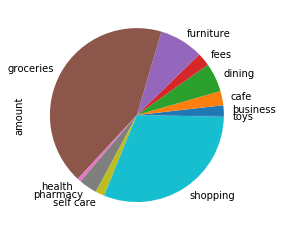

In [92]:
df[df['type']=='debit'].groupby(['category'])['amount'].agg('sum').map(abs).plot(kind='pie')
df[df['type']=='debit'].groupby(['category'])['amount'].agg('sum').map(abs)